# Data preaparation


In [1]:
import uproot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from collections import namedtuple, defaultdict
import open3d as o3d
import random
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
uproot.__version__

'5.0.9'

In [3]:
!ls ..

CaloGNN.png                          Untitled.ipynb
GNNKeras.ipynb                       ZacClub.ipynb
LLP_for_Calo.ipynb                   debottam@237.93.105.92
LLP_time-Copy1.ipynb                 fixed_length.py
LLP_time.ipynb                       input.txt
LLP_time_1.ipynb                     karate.edgelist
MLBasedCaloClustering                mlp-0000.params
MLBasedCaloClusteringPipeLine        mlp-symbol.json
ML_01.ipynb                          mxHybrid.ipynb
ML_Cell_data                         mxnet_exported_mlp.onnx
ML_for_Calo.ipynb                    my_env
ML_for_Calo_students.ipynb           saved_model
MyxAODAnalysis_300evnts.outputs.root trackML.ipynb
MyxAODAnalysis_withNB.outputs.root


In [5]:
file = uproot.open("../MyxAODAnalysis_withNB.outputs.root")

In [6]:
file.keys()

['analysis;1']

In [7]:
tree = file['analysis']

In [9]:
branches = tree.arrays()

In [10]:
# this one just dealing with 1 event (e.g. 0th event)
cell_coordinate_x = branches['cell_x'][1]
cell_coordinate_y = branches['cell_y'][1]
cell_coordinate_z = branches['cell_z'][1]
cell_eta = branches['cell_eta'][1]
cell_phi = branches['cell_phi'][1]
cell_subCalo = branches['cell_subCalo'][1]
cell_sampling = branches['cell_sampling'][1]
cell_weight = branches['cell_weight'][1]
cell_truth = branches['cell_truth'][1]
cell_to_cluster_e = branches['cell_to_cluster_e'][1]
cell_noiseSigma = branches['cell_noiseSigma'][1]
cell_SNR = branches['cell_SNR'][1]
cell_time = branches['cell_time'][1]
cellsNo_cluster = branches['cellsNo_cluster'][1]
clustersNo_event = branches['clustersNo_event'][1]
cell_cluster_index = branches['cell_cluster_index'][1]
cell_e = branches['cell_e'][1]
cluster_to_cell_indices = branches['cluster_to_cell_indices'][1]

In [11]:
# convert them to numpy array otherwise they I believe behave like lists
cell_coordinate_x = np.array(cell_coordinate_x)
cell_coordinate_y = np.array(cell_coordinate_y)
cell_coordinate_z = np.array(cell_coordinate_z)
cell_eta = np.array(cell_eta)
cell_phi = np.array(cell_phi)
cell_subCalo = np.array(cell_subCalo)
cell_sampling = np.array(cell_sampling)
cell_weight = np.array(cell_weight)
cell_truth = np.array(cell_truth)
cell_to_cluster_e = np.array(cell_to_cluster_e)
cell_noiseSigma = np.array(cell_noiseSigma)
cell_SNR = np.array(cell_SNR)
cell_time = np.array(cell_time)
cellsNo_cluster = np.array(cellsNo_cluster)
clustersNo_event = np.array(clustersNo_event)
cell_to_cluster_index = np.array(cell_cluster_index)
cell_e = np.array(cell_e)
#cluster_to_cell_indices = np.array(cluster_to_cell_indices)

# Description of data set:
We decided to use following features from an event
### Geometric features:

##### 1. cell_coordinate_x (mm)
##### 2. cell_coordinate_y (mm)
##### 3. cell_coordinate_z (mm)
##### 4. cell_subCalo          : LAREM = 0, LARHEC = 1, LARFCAL = 2, TILE = 3, LARMINIFCAL = 4, NSUBCALO = 5,
##### 5. cell_sampling         : More granular information of the subcalo above

### Deposited energy related features:

##### 6. cell_SNR          : signal to noise ratio of a cell
##### 7. cell_e               : Energy deposited in a cell in MeV

### Topocluster related cell features:

##### 8. cell_truth             : 0/1 whether cell takes part in a cluster or not
##### 9. cell_weight            : could have more than 1 entry (value 0 to 1) but using the max weight for simplicity
##### 10. cell_to_cluster_index  : index/id of the cluster where the cell has maximum weight (again for initial study)
##### 11. cell_to_cluster_e      : energy of the cluster where the cell has maximum weight (again for initial study)

# Visualization of cell geometry

### A. Y-Z coordinates (Tile cells are in red)

Text(0, 0.5, 'y direction (mm)')

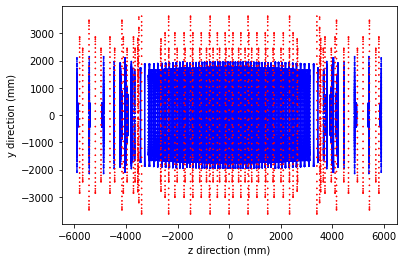

In [14]:
s = 1
col = np.where(cell_subCalo==3,'r','b')
plt.scatter(cell_coordinate_z, cell_coordinate_y, marker='.', s=s, c=col)
plt.xlabel("z direction (mm)")
plt.ylabel("y direction (mm)")

### B. X-Y coordinates (Tile cells are in red)

Text(0, 0.5, 'y direction (mm)')

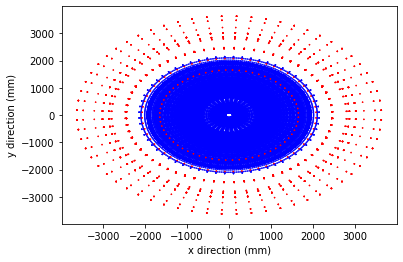

In [15]:
plt.scatter(cell_coordinate_x, cell_coordinate_y, marker='.', s=s, c=col)
plt.xlabel("x direction (mm)")
plt.ylabel("y direction (mm)")

## Visualization of the features 

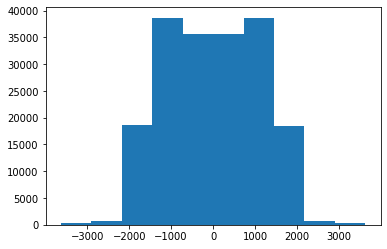

In [13]:
plt.hist(cell_coordinate_x)
plt.show()

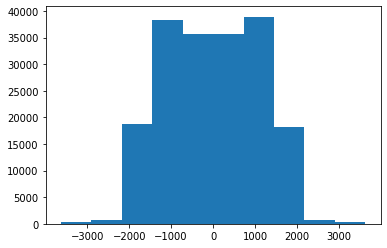

In [14]:
plt.hist(cell_coordinate_y)
plt.show()

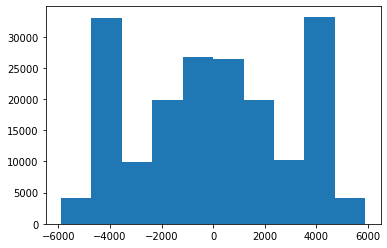

In [15]:
plt.hist(cell_coordinate_z)
plt.show()

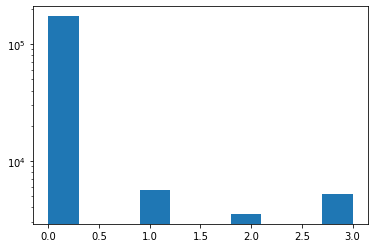

In [16]:
plt.hist(cell_subCalo)
plt.yscale("log")
plt.show()

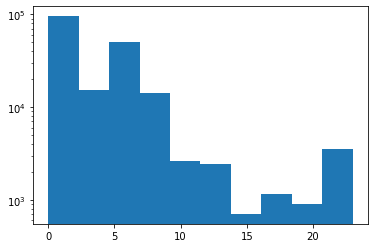

In [17]:
plt.hist(cell_sampling)
plt.yscale("log")
plt.show()

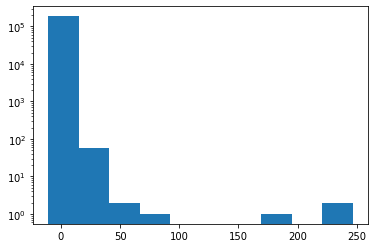

In [18]:
plt.hist(cell_SNR)
plt.yscale("log")
plt.show()

In [19]:

participatingCell_Indx = [i for i in range(len(cell_truth)) if cell_truth[i]==1]
nonParticipatingCell_Indx = [i for i in range(len(cell_truth)) if cell_truth[i]==0]

In [26]:
participatingCell_SNR = cell_SNR[participatingCell_Indx]
nonParticipatingCell_SNR = cell_SNR[nonParticipatingCell_Indx]

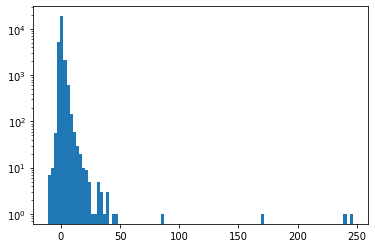

In [59]:
plt.hist(participatingCell_SNR, bins=100)
#plt.xlim(-7,1)
plt.yscale("log")
plt.show()

In [79]:
cellsWithSNR0andless = [i for i in range(len(participatingCell_SNR)) if participatingCell_SNR[i]<=0]

In [80]:
len(cellsWithSNR0andless)

10302

In [71]:
len(participatingCell_SNR)

27294

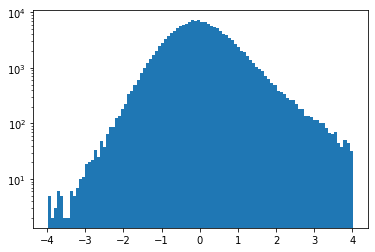

In [60]:
plt.hist(nonParticipatingCell_SNR, bins =100)
#plt.xlim(-0.25,0.25)
plt.yscale("log")
plt.show()

In [22]:
min(participatingCell_Indx)

394

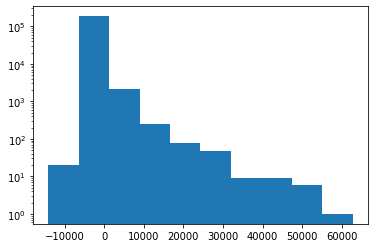

In [76]:
plt.hist(cell_e)
plt.yscale("log")
plt.show()

In [74]:
participatingCellE=cell_e[participatingCell_Indx ]
nonParticipatingCellE = cell_e[nonParticipatingCell_Indx ]

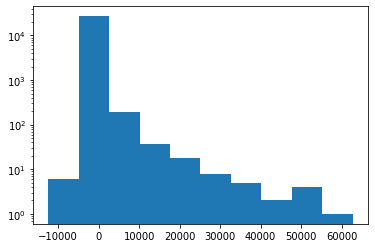

In [73]:
plt.hist(participatingCellE)
plt.yscale("log")
plt.show()

In [77]:
cellsWithE0andless = [i for i in range(len(participatingCellE)) if participatingCellE[i]<=0]

In [78]:
len(cellsWithE0andless)

10302

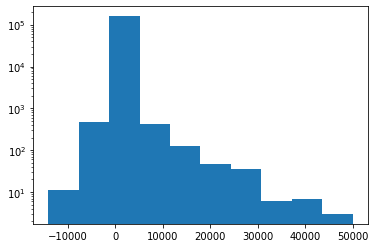

In [75]:
plt.hist(nonParticipatingCellE)
plt.yscale("log")
plt.show()

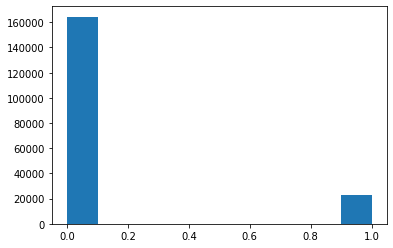

In [20]:
plt.hist(cell_truth)
plt.show()

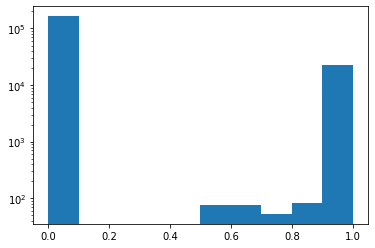

In [21]:
plt.hist(cell_weight)
plt.yscale("log")
plt.show()

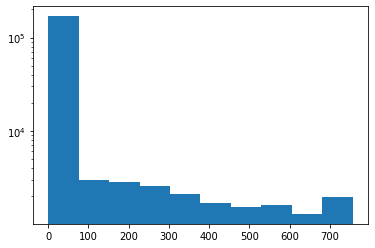

In [22]:
plt.hist(cell_to_cluster_index)
plt.yscale("log")
plt.show()

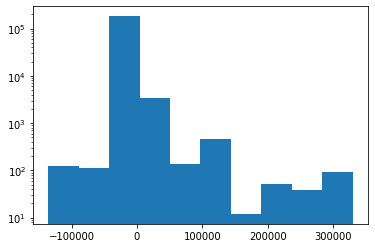

In [23]:
plt.hist(cell_to_cluster_e)
plt.yscale("log")
plt.show()

# Dealing with shared cells:
### To reduce complexity we are keeping shared cells (shared by >1 clusters) in only single cluster where it contributed the most. e.g. if cell c is shared between cluster a and b by 90% and 10% respectively then we are keeping cell c in cluster a only

In [16]:
sharedCells = [i for i in range(len(cell_weight)) if cell_weight[i]>0 and cell_weight[i]<1]

In [17]:
len(sharedCells)

757

#### keeping the shared cells in the cluster where they contribute most

In [18]:
cluster_to_cell_indices_copy = []
for i in range(len(cluster_to_cell_indices)):
    cell_copy =[]
    for cell in cluster_to_cell_indices[i]:
        if cell in sharedCells and cell_to_cluster_index[cell] != i+1:
            continue
        cell_copy.append(cell)
    cluster_to_cell_indices_copy.append(cell_copy)

In [19]:
len(cluster_to_cell_indices_copy)

757

# Preparing data with required features

In [20]:
cell_coordinate_xT = np.transpose(np.expand_dims(cell_coordinate_x , axis=0))
cell_coordinate_yT = np.transpose(np.expand_dims(cell_coordinate_y , axis=0))
cell_coordinate_zT = np.transpose(np.expand_dims(cell_coordinate_z , axis=0))
cell_etaT = np.transpose(np.expand_dims(cell_eta , axis=0))
cell_phiT = np.transpose(np.expand_dims(cell_phi , axis=0))
cell_samplingT = np.transpose(np.expand_dims(cell_sampling , axis=0))
cell_subCaloT = np.transpose(np.expand_dims(cell_subCalo , axis=0))
cell_SNRT = np.transpose(np.expand_dims(cell_noiseSigma, axis=0))
cell_eT = np.transpose(np.expand_dims(cell_e , axis=0))
cell_weightT = np.transpose(np.expand_dims(cell_weight , axis=0))
cell_to_cluster_indexT = np.transpose(np.expand_dims(cell_to_cluster_index, axis=0))
cell_to_cluster_eT = np.transpose(np.expand_dims(cell_to_cluster_e, axis=0))

In [21]:
cell_SNRT.shape

(187652, 1)

In [22]:
data = np.concatenate((cell_coordinate_xT, cell_coordinate_yT, cell_coordinate_zT,
                       cell_etaT,cell_phiT,
                       cell_samplingT,
                       cell_SNRT,
                       cell_eT),axis=1)

In [23]:
data.shape

(187652, 8)

In [24]:
arr = np.argwhere(np.isnan(cell_SNR))

In [23]:
arr

array([[186986],
       [187352]])

# Applying minmax scaler

In [81]:
sc_X = MinMaxScaler()
normalized = sc_X.fit_transform(data)

# Pairing cell indices those belong to same cluster

In [25]:
true_pairs = []
for cluster in cluster_to_cell_indices_copy:
    for i in range(len(cluster)):
        for j in range(i + 1, len(cluster)):
            true_pairs.append((cluster[i], cluster[j]))
            

In [26]:
len(true_pairs)

2199950

# Random Pairng cells belonging different clusters or lone-cell

In [27]:
false_pairs = []
for i in range(len(cluster_to_cell_indices_copy)):
    i_list = cluster_to_cell_indices[i]
    rand_idx = random.randrange(len(i_list))
    random_inum = i_list[rand_idx]
    for j in range(i + 1, len(cluster_to_cell_indices_copy)):
        j_list = cluster_to_cell_indices_copy[j]
        rand_jdx = random.randrange(len(j_list))
        random_jnum = j_list[rand_jdx]
        if random_jnum != random_inum:
            false_pairs.append((random_inum,random_jnum))

In [28]:
len(false_pairs)

286145

In [29]:
loneCells_index = [i for i in range(len(cell_truth)) if cell_truth[i] == 0]

In [30]:
loneCells_index.index(186986)

163888

In [31]:
loneCells_index.index(187352)

164189

In [32]:
for i in range(len(loneCells_index)):
    if i == 163888 or i == 164189:
        continue
    rand_clusterjdx = random.randrange(len(cluster_to_cell_indices_copy))
    j_list = cluster_to_cell_indices_copy[rand_clusterjdx]
    rand_jdx = random.randrange(len(j_list))
    random_jnum = j_list[rand_jdx]
    false_pairs.append((loneCells_index[i],random_jnum))

In [33]:
len(false_pairs)

450580

In [66]:
nonParticipatingCell = [i for i in range(len(cell_truth)) if cell_truth[i]==0]

In [67]:
with h5py.File('./nonParticipatingCell.hdf5', 'w') as f: 
    dset = f.create_dataset("nonParticipatingCell", data = nonParticipatingCell)

In [35]:
# creating pair and no pair indices file
with h5py.File('./true_pair_index_ev1.hdf5', 'w') as f: 
    dset = f.create_dataset("true_pair", data = true_pairs)

with h5py.File('./false_pair_index_ev1.hdf5', 'w') as f: 
    dset = f.create_dataset("false_pair", data = false_pairs)
    
with h5py.File('./cellFeatures_ev1.hdf5', 'w') as f: 
    dset = f.create_dataset("cellFeatures", data = data)
    
with h5py.File('./sharedCellsIndices.hdf5', 'w') as f: 
    dset = f.create_dataset("sharedCellsIndices", data = sharedCells)
